We will try to fit the following model

<img src="model.jpg" />

We'll try to model something relatively close to the 88 soils example

So we'll let the unobserved variables $\beta_0=16$ , $\beta_1 = -3$, and $\Lambda = \begin{bmatrix}1\\ \vdots \\-1\end{bmatrix}$.

The we'll let the observed variable $g_j \in [3, 9]$

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm, poisson, multinomial, multivariate_normal
%matplotlib inline

In [2]:
num_samples = 20
num_features = 32
rank = 3
gradient = np.linspace(0, 10, num_samples)
mu = np.linspace(0, 10, num_features)
sigma = 2
xs = [norm.pdf(gradient, loc=mu[i], scale=sigma)
      for i in range(len(mu))]
table = np.vstack(xs).T
table = pd.DataFrame(table)
table.index = table.index.astype(np.str)
table.columns = table.columns.astype(np.str)

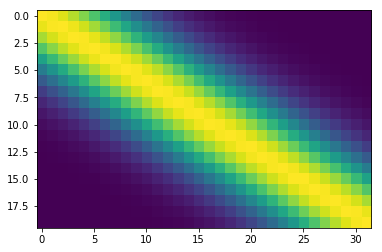

In [3]:
plt.imshow(table.values, aspect='auto', interpolation='nearest')

In [4]:
from gneiss.cluster import rank_linkage
x = pd.Series(np.arange(num_features))
x.index = x.index.astype(np.str)
tree = rank_linkage(x)

In [5]:
print(tree.ascii_art())

                                                  /-0
                                        /y15-----|
                                       |          \-1
                              /y7------|
                             |         |          /-2
                             |          \y16-----|
                             |                    \-3
                    /y3------|
                   |         |                    /-4
                   |         |          /y17-----|
                   |         |         |          \-5
                   |          \y8------|
                   |                   |          /-6
                   |                    \y18-----|
                   |                              \-7
          /y1------|
         |         |                              /-8
         |         |                    /y19-----|
         |         |                   |          \-9
         |         |          /y9------|
         |         |         |

In [6]:
from gneiss.composition import ilr_transform
balances = ilr_transform(table, tree)

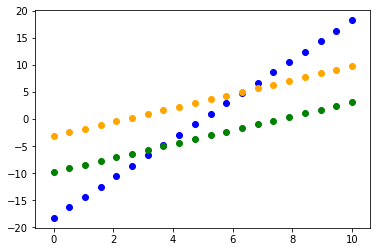

In [18]:
plt.scatter(gradient, balances.y0, label='y0', c='b')
plt.scatter(gradient, balances.y1, label='y1', c='#FFA500')
plt.scatter(gradient, balances.y2, label='y2', c='g')

In [10]:
def ols(Y, X):
    n, p = X.shape
    inv = np.linalg.pinv(np.dot(X.T, X))
    cross = np.dot(inv, X.T)
    beta = np.dot(cross, Y)
    pY = np.dot(X, beta)
    resid = (Y - pY)
    sst = (Y - Y.mean(axis=0))
    sse = (resid**2).sum(axis=0)

    sst_balance = ((Y - Y.mean(axis=0))**2).sum(axis=0)

    sse_balance = (resid**2).sum(axis=0)
    ssr_balance = (sst_balance - sse_balance)

    df_resid = n - p + 1
    mse = sse / df_resid
    # t tests
    cov = np.linalg.pinv(np.dot(X.T, X))
    return pY, resid, beta, cov

In [11]:
Y = balances.values
X = gradient.reshape(-1, 1)
X = np.hstack((np.ones(len(X)).reshape(-1, 1), X.reshape(-1, 1)))
pY, resid, beta, cov = ols(Y, X)

In [12]:
beta0 = np.ravel(beta[0, :]).reshape(-1, 1)
beta1 = np.ravel(beta[1, :]).reshape(-1, 1)

In [13]:
from numpy.random import multivariate_normal, multinomial
from gneiss.balances import balance_basis
from gneiss.util import band_diagonal
from skbio.stats.composition import ilr_inv

sigma = np.eye(len(beta0)) 
#sigma = band_diagonal(len(beta0), 2)
#sigma = sigma * 2
#sigma = np.hstack((np.zeros(len(beta0)).reshape(-1, 1), sigma))
#sigma[0, 0] = 1

y = X.dot(beta)
Ys = np.vstack([multivariate_normal(y[i, :], sigma) for i in range(y.shape[0])])
basis, _ = balance_basis(tree)
Yp = ilr_inv(Ys, basis)

N = 200   # sampling depth
Yc = np.vstack(multinomial(N, Yp[i, :]) for i in range(y.shape[0]))

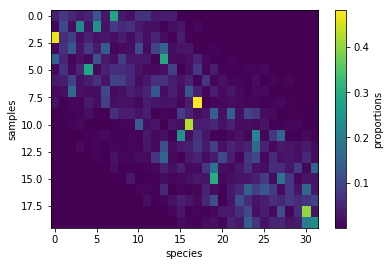

In [14]:
plt.imshow(Yp, aspect='auto', interpolation='nearest')
plt.colorbar(label='proportions')
plt.xlabel('species')
plt.ylabel('samples')

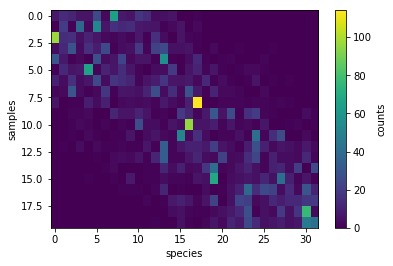

In [15]:
plt.imshow(Yc, aspect='auto', interpolation='nearest')
plt.colorbar(label='counts')
plt.xlabel('species')
plt.ylabel('samples')

In [16]:
np.savetxt('sim.txt', Yc)